# Diffrax Scratch
Scratch code testing ODEs using diffrax

In [17]:
# %% Import JAX and enable 64-bit precision
import jax
jax.config.update("jax_enable_x64", True)

In [18]:
# %% Import other libraries
import equinox as eqx
import interpax
import diffrax
import optimistix as optx

import jax.numpy as jnp
import jax.tree_util as jtu
from dataclasses import dataclass
from functools import partial
import numpy as np
from collections import namedtuple
from typing import NamedTuple
import matplotlib.pyplot as plt

from netCDF4 import Dataset

from jaxtyping import ArrayLike, Real

In [19]:
# %% Load my own libraries
%load_ext autoreload
%autoreload 2
from c1lgkt.jax.fields.equilibrium import Equilibrium
import c1lgkt.jax.particles.particle_motion as particle_motion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


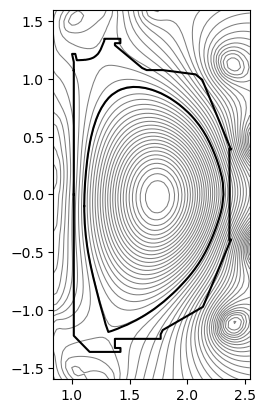

In [20]:
# %% Test loading equilibrium
eq = Equilibrium.from_eqdfile('./tests/D3D141451.eqd')

plt.figure()
ax = plt.subplot(111)
eq.plot_magnetic_geometry(ax)

xgcdata = Dataset(R'D:\Documents\Globus\XGC1.nc')

In [12]:
type PusherState = tuple[Real[ArrayLike, "..."], Real[ArrayLike, "..."], Real[ArrayLike, "..."], Real[ArrayLike, "..."], Real[ArrayLike, "..."]]

In [21]:
# %% Pusher along magnetic field lines

term = diffrax.ODETerm(particle_motion.f_fieldline)
solver = diffrax.Dopri5()
saveat = diffrax.SaveAt(ts=jnp.linspace(0, 10, 1000))
args = particle_motion.PusherArgs(eq=eq)
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)

r0 = jnp.array(1.5)
z0 = jnp.array(0.0)
varphi0 = jnp.zeros_like(r0)

sol = diffrax.diffeqsolve(term, solver, t0=0, t1=10, dt0=1e-3, y0=(r0, varphi0, z0),
                          saveat=saveat, args=args,
                          stepsize_controller=stepsize_controller)

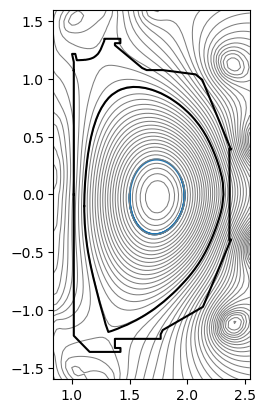

In [22]:
plt.figure()

r, varphi, z = sol.ys
ax = plt.subplot(111)
ax.plot(r, z)
eq.plot_magnetic_geometry(ax)



In [23]:
# %% Pusher for drift-kinetic particles
pp = particle_motion.deut

# Load zonal electric potential
tind = 400
interp_phi = interpax.Interpolator1D(xgcdata['psi00'][:].filled(), xgcdata['pot00'][tind,:].filled()*1e-3, method='cubic2')

term = diffrax.ODETerm(particle_motion.f_driftkinetic_midplane)
solver = diffrax.Dopri5()
saveat = diffrax.SaveAt(t0=True, t1=True, steps=True)
args = particle_motion.PusherArgs(eq=eq, pp=pp, zonal_fields=interp_phi)
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)

# Termination condition for passing particles
def cond_copassing(t, y, args, **kwargs):
    r, varphi, z, vll, mu, theta_pol, theta_vll = y
    # Pick only the first particle if multiple particles are being pushed
    return jnp.ravel(theta_pol)[0] - 2 * jnp.pi

def cond_ctrpassing(t, y, args, **kwargs):
    r, varphi, z, vll, mu, theta_pol, theta_vll = y
    return jnp.ravel(theta_pol)[0] + 2 * jnp.pi

def cond_bounce(t, y, args, **kwargs):
    r, varphi, z, vll, mu, theta_pol, theta_vll = y
    return jnp.ravel(theta_vll)[0] - 2 * jnp.pi

root_finder = optx.Newton(rtol=1e-5, atol=1e-5)
event = diffrax.Event((cond_copassing, cond_ctrpassing, cond_bounce), root_finder)

def orbit_freqs(y0):
    sol = diffrax.diffeqsolve(term, solver, t0=0, t1=1.0, dt0=5e-4, y0=y0,
                            args=args,
                            stepsize_controller=stepsize_controller,
                            event=event,
                            throw=False)
    
    r, varphi, z, vll, mu, theta_pol, theta_vll = sol.ys

    omega_tor = varphi[-1] / sol.ts[-1]
    winding_pol = theta_pol[-1] / (2 * jnp.pi)
    winding_vll = theta_vll[-1] / (2 * jnp.pi)
    # Note: this is the unsigned frequency; need to multiply by the appropriate winding number to get the signed frequency
    omega_pol = 2*jnp.pi / sol.ts[-1]

    return omega_tor, omega_pol, winding_pol, winding_vll, sol

batched_bounce_freqs = jax.vmap(orbit_freqs)



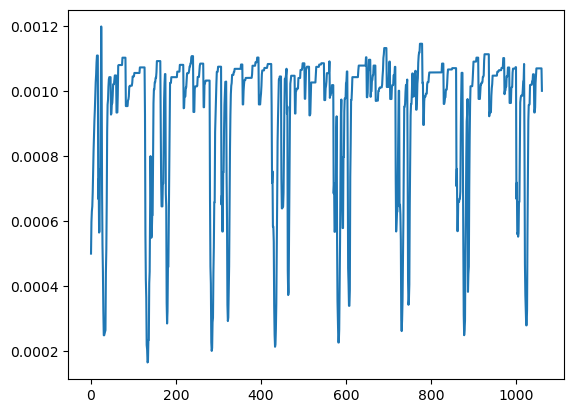

In [24]:
# %% Push multiple particles and check timesteps
%matplotlib inline
n_part = 1024
r0 = jnp.array(np.random.rand(n_part)*0.15 + 2.1)
z0 = jnp.zeros_like(r0)
varphi0 = jnp.zeros_like(r0)
vll0 = jnp.array(np.random.randn(n_part)*pp.vt)
mu0 = jnp.ones_like(r0) * pp.m * (pp.vt **2) / (2 * 1.0)
theta_pol0 = jnp.zeros_like(r0)
theta_vll0 = jnp.zeros_like(r0)

sol = diffrax.diffeqsolve(term, solver, t0=0, t1=1.0, dt0=5e-4, y0=(r0, z0, varphi0, vll0, mu0, theta_pol0, theta_vll0),
                            args=args,
                            saveat=saveat,
                            stepsize_controller=stepsize_controller,
                            throw=False)

plt.figure()
plt.plot(np.diff(sol.ts))

In [25]:
# %% Compute frequencies
inputs = (r0, varphi0, z0, vll0, mu0, theta_pol0, theta_vll0)
freqs = batched_bounce_freqs(inputs)

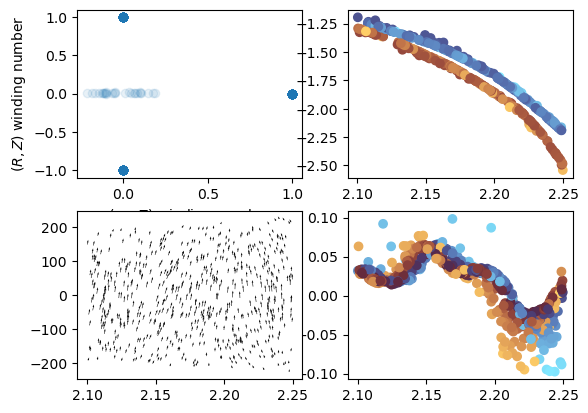

In [26]:
# %% Plot of winding numbers and q profiles
%matplotlib inline
omega_tor, omega_pol, winding_pol, winding_vll, sols = freqs

plt.figure()
# Plot winding numbers
plt.subplot(221)
plt.scatter(winding_vll, winding_pol, alpha=0.1)
plt.xlabel(R'$(v_\parallel, Z)$ winding number')
plt.ylabel(R'$(R,Z)$ winding number')

# Plot passing particles
plt.subplot(222)
filter = np.logical_or((np.round(winding_pol) == -1), (np.round(winding_pol) == +1))
plt.scatter(r0[filter], omega_tor[filter] / omega_pol[filter] * np.round(winding_pol)[filter], c=vll0[filter], cmap='managua')

# Plot trapped particles
plt.subplot(224)
filter = (np.round(winding_vll) != 0)
plt.scatter(r0[filter], omega_tor[filter] / omega_pol[filter], c=vll0[filter], cmap='managua')

# Plot frequencies for trapped particles
plt.subplot(223)
filter = np.logical_and((np.round(winding_pol) == 0), (np.round(winding_vll) == +1))
plt.quiver(r0[filter], vll0[filter], omega_tor[filter] / jnp.std(omega_tor[filter]), omega_pol[filter] / jnp.std(omega_pol[filter]))

In [115]:
np.min(2*np.pi / omega_pol[np.round(winding_vll) == 1])

Array(0.13112415, dtype=float64)

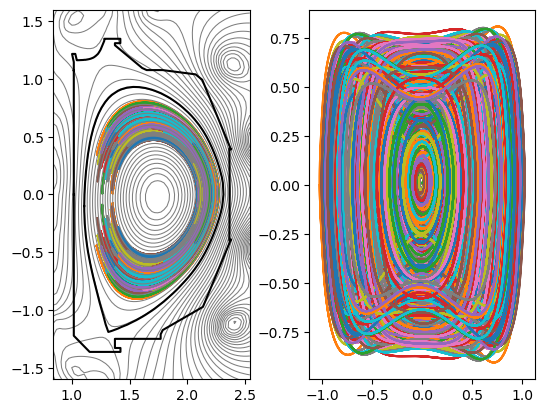

In [27]:
# %% Plot trajectory of individual particle(s)
plt.figure()

r, varphi, z, vll, mu, theta_pol, theta_vll = sol.ys

ax = plt.subplot(121)
ax2 = plt.subplot(122)
pinds = np.nonzero(np.logical_and(np.round(winding_pol) == 0, np.round(winding_vll) == 1))

for pind in pinds:
    
    ax.plot(r[:,pind], z[:,pind])
    ax2.plot(vll[:,pind]/pp.vt, z[:,pind])

eq.plot_magnetic_geometry(ax)


In [105]:
vll0[pinds] / pp.vt

Array([ 0.0009079 , -0.02366116,  0.01120505,  0.00757214, -0.01481217,
        0.00586624, -0.03365677, -0.04733046, -0.017866  , -0.04230128,
       -0.02908372, -0.05206778, -0.03765038,  0.00829397,  0.00039618,
        0.00870558, -0.00892743, -0.00436692,  0.00187736, -0.02681687,
       -0.04604559,  0.01454708,  0.01613944, -0.00267089], dtype=float64)

Array(218.84735742, dtype=float64, weak_type=True)